In [1]:
import scipy.io
import os
import tensorflow as tf
import model

2024-04-16 11:23:18.595577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 11:23:18.595647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 11:23:18.598667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 11:23:18.611610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 11:23:19.422791: W tensorflow/compiler/tf2

In [16]:
working_dir = os.getcwd()

file_path = os.path.join(working_dir, 'jaxpi', 'examples', 'allen_cahn','data', 'allen_cahn.mat')

data = scipy.io.loadmat(file_path)

# get data for model
x = data['x'].flatten()
t = data['t'].flatten()
usol = data['usol']

In [17]:
pinn = model.ConventionalAllenCahnPINN(t,x,usol)

Shape of Data
t: (201,)
x: (512,)
usol: (201, 512)
t_initial: (512,)
x_initial: (512,)
usol_initial: (512,)
x_train: (102912,)
t_train: (102912,)
usol_train: (102912,)
x_negative_bound: (201,)
x_positive_bound: (201,)
t_bc: (201,)


In [18]:
pinn.train(1000)

Epoch 1
Calculating Loss Value
Updating Weights
Epoch 2
Calculating Loss Value
Updating Weights
Epoch 3
Calculating Loss Value
Updating Weights
Epoch 4
Calculating Loss Value
Updating Weights
Epoch 5
Calculating Loss Value
Updating Weights
Epoch 6
Calculating Loss Value
Updating Weights
Epoch 7
Calculating Loss Value
Updating Weights
Epoch 8
Calculating Loss Value
Updating Weights
Epoch 9
Calculating Loss Value
Updating Weights
Epoch 10
Calculating Loss Value
Updating Weights
Epoch 11
Calculating Loss Value
Updating Weights
Epoch 12
Calculating Loss Value
Updating Weights
Epoch 13
Calculating Loss Value
Updating Weights
Epoch 14
Calculating Loss Value
Updating Weights
Epoch 15
Calculating Loss Value
Updating Weights
Epoch 16
Calculating Loss Value
Updating Weights
Epoch 17
Calculating Loss Value
Updating Weights
Epoch 18
Calculating Loss Value
Updating Weights
Epoch 19
Calculating Loss Value
Updating Weights
Epoch 20
Calculating Loss Value
Updating Weights
Epoch 21
Calculating Loss Val

In [5]:
import numpy as np

In [6]:
print(x.shape)
print(t.shape)

(512,)
(201,)


In [19]:
results = []
times = []

xs = tf.cast(tf.convert_to_tensor(x), dtype=tf.float32)

for i in range(201):
    times.append(t[i])

    ts = tf.cast(tf.convert_to_tensor(np.array([t[i]]*512)), dtype=tf.float32)

    results.append(pinn.residual_loss(ts,xs))

In [20]:
print(results)

[<tf.Tensor: shape=(), dtype=float32, numpy=2.8959532>, <tf.Tensor: shape=(), dtype=float32, numpy=2.8386552>, <tf.Tensor: shape=(), dtype=float32, numpy=2.7819073>, <tf.Tensor: shape=(), dtype=float32, numpy=2.725712>, <tf.Tensor: shape=(), dtype=float32, numpy=2.6700704>, <tf.Tensor: shape=(), dtype=float32, numpy=2.614982>, <tf.Tensor: shape=(), dtype=float32, numpy=2.5604484>, <tf.Tensor: shape=(), dtype=float32, numpy=2.5064704>, <tf.Tensor: shape=(), dtype=float32, numpy=2.453049>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4001858>, <tf.Tensor: shape=(), dtype=float32, numpy=2.3478816>, <tf.Tensor: shape=(), dtype=float32, numpy=2.296136>, <tf.Tensor: shape=(), dtype=float32, numpy=2.2449505>, <tf.Tensor: shape=(), dtype=float32, numpy=2.1943264>, <tf.Tensor: shape=(), dtype=float32, numpy=2.144264>, <tf.Tensor: shape=(), dtype=float32, numpy=2.0947647>, <tf.Tensor: shape=(), dtype=float32, numpy=2.045829>, <tf.Tensor: shape=(), dtype=float32, numpy=1.9974571>, <tf.Tensor: sha

Text(0, 0.5, 'Residual Loss')

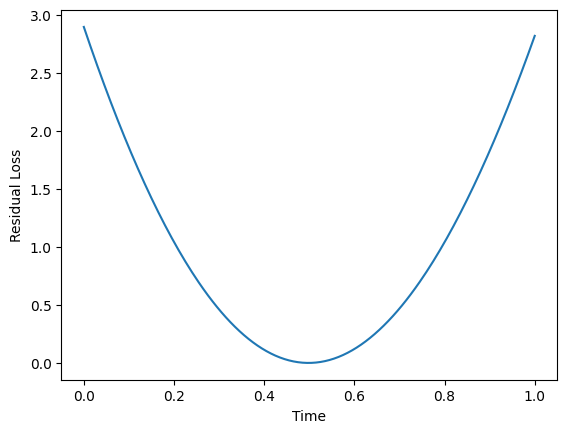

In [21]:
import matplotlib.pyplot as plt

plt.plot(times,results)
plt.xlabel('Time')
plt.ylabel('Residual Loss')

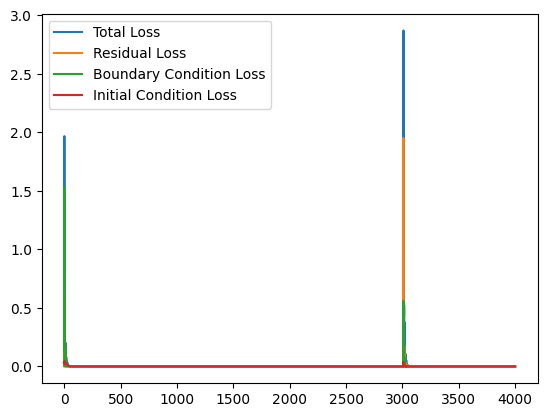

In [9]:
plt.plot(pinn.log['total_loss'], label='Total Loss')
plt.plot(pinn.log['residual_loss'], label='Residual Loss')
plt.plot(pinn.log['boundary_loss'], label='Boundary Condition Loss')
plt.plot(pinn.log['initial_loss'], label='Initial Condition Loss')

plt.legend()


In [44]:
print(pinn.log['total_loss'][-1])

1.7048290652415641e-18


In [22]:
with tf.GradientTape(persistent=True) as loss_tape:
    loss_tape.reset()
    loss_tape.watch(pinn.model.trainable_variables)
    
    total_loss, loss_r, loss_ic, loss_bc = pinn.loss_function()


ic_grad = loss_tape.gradient(loss_ic, pinn.model.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)
bc_grad = loss_tape.gradient(loss_bc, pinn.model.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)
r_grad = loss_tape.gradient(loss_r, pinn.model.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)



Calculating Loss Value


In [25]:
print(len(r_grad))
print(len(ic_grad))

10
10


In [26]:

for i in range(10):
    r_grad[i] = tf.reshape(r_grad[i],[-1])
    ic_grad[i] = tf.reshape(ic_grad[i],[-1])

print(r_grad)

[<tf.Tensor: shape=(400,), dtype=float32, numpy=
array([ 2.36679218e-11,  6.85296542e-11, -2.39350866e-11,  1.26185520e-11,
       -7.50105533e-12,  1.25468412e-11,  3.98318115e-11,  3.17466088e-11,
        3.58030237e-11, -1.46434011e-11,  1.16464616e-10,  1.78339375e-11,
        6.22198612e-11, -1.11591264e-10,  1.41520476e-13, -3.86090188e-11,
       -2.59607895e-12, -4.95985891e-11,  4.21804605e-11,  5.53790382e-11,
       -3.42492770e-11, -6.73659652e-12,  2.98567213e-11, -1.56132277e-11,
        3.65331758e-11,  8.76821254e-11, -3.80931953e-11,  7.53413512e-11,
       -3.80598573e-11, -3.94794510e-11, -9.38438650e-12,  7.49981674e-11,
       -2.40429569e-11,  7.01629380e-11, -6.12777329e-11, -1.75298979e-12,
        1.14648908e-10,  4.31346972e-11, -1.52216365e-11,  2.58502057e-11,
        1.60733718e-11, -3.85739461e-11,  4.70359481e-11,  5.82671689e-11,
        6.16980980e-11, -7.28972022e-11,  3.02379857e-11,  3.79165518e-11,
       -2.46388170e-11,  8.33516381e-11,  3.0934109

In [33]:
r_grad = tf.concat(r_grad, axis=0).numpy()
ic_grad = tf.concat(ic_grad, axis=0).numpy()

r_grad = r_grad * (10**9)
ic_grad = ic_grad * (10**9)

print(r_grad)
print(ic_grad)



[ 0.02366792  0.06852965 -0.02393509 ... -0.02451977 -0.00771218
  2.96546698]
[ 0.          0.          0.         ... -0.05693268 -0.01186826
 -1.74622983]


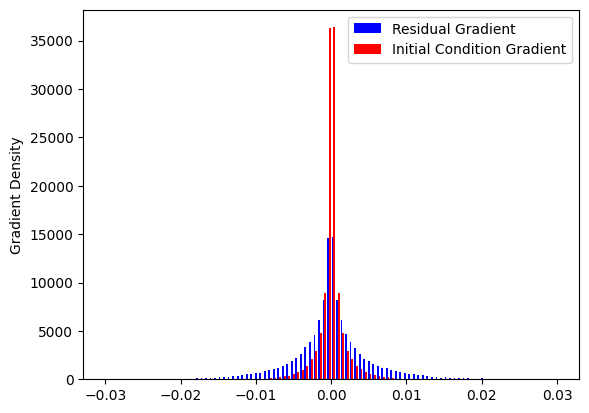

In [43]:
plt.hist([r_grad,ic_grad],bins=100, color=['blue','red'], range=(-0.03,.03), label=['Residual Gradient', 'Initial Condition Gradient'])
plt.ylabel('Gradient Density')
plt.legend()